In [1]:
import numpy as np
import xarray as xr
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

import matplotlib.patches as patches
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import pandas as pd
import tarfile
from datetime import datetime, timedelta
from dateutil.parser import parse

import xroms
from xhistogram.xarray import histogram
from scipy import signal

Let's try to subsample the data only from 2010 for one month of Jan and Jul.

In [3]:
path = '/d1/shared/TXLA_ROMS/output_20yr_obc/2010/ocean_his_00*.nc'
ds = xroms.xroms.open_netcdf(path, chunks = {'ocean_time':1})

ds, grid = xroms.xroms.roms_dataset(ds, Vtransform = None)

zetamean = xr.open_dataset('zeta_20yrmean.nc')

In [4]:
domain = ds.zeta.where((ds.lon_rho>-94.5) 
                     & (ds.lon_rho<-91.5) 
                     & (ds.h>10) 
                     & (ds.h<80),
                     drop = True)

In [5]:
dsjan = domain.sel(ocean_time = '2010-1')[::3,:,::5] #every 3 hours, every 5th xi point
dsjul = domain.sel(ocean_time = '2010-7')[::3,:,::5]

dsm = dsjan.combine_first(dsjul)

In [8]:
zetamn = zetamean.zeta.where((ds.lon_rho>-94.5) 
                     & (ds.lon_rho<-91.5) 
                     & (ds.h>10) 
                     & (ds.h<80),
                     drop = True)

mn20yr = zetamn.isel(xi_rho = slice(0,181,5))
sla = dsm-mn20yr

Text(0.5, 1.0, 'TX-LA Mean sea level: 1994-2017')

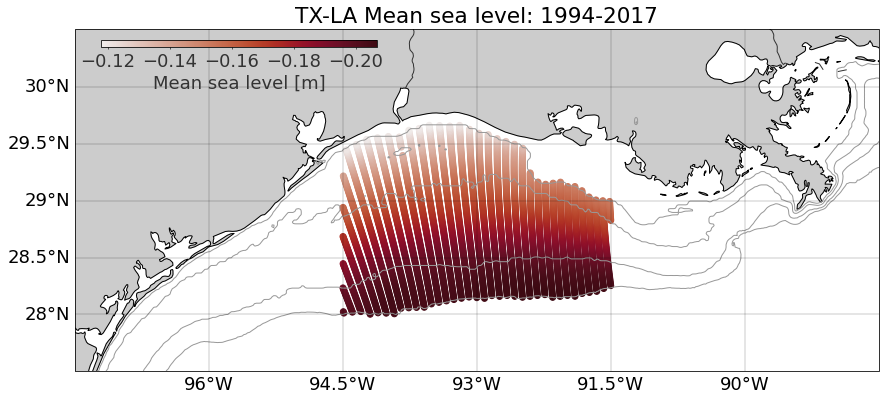

In [214]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=ccrs.Mercator(central_longitude=-85.0))

lon_rho = dsjan['lon_rho'].values
lat_rho = dsjan['lat_rho'].values
hlevs = [10, 20, 50, 80] # isobath contour depths

mappable = ax.scatter(mn20yr.lon_rho[:], mn20yr.lat_rho[:], c = mn20yr,
                         cmap = cmo.amp_r, transform = cartopy.crs.PlateCarree(),
                        )

land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])
states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')

gl = ax.gridlines(linewidth=0.4, color='black', alpha=0.5, linestyle='-', draw_labels=True)
ax.set_extent([-94, -91.5, 28.3, 29.6], ccrs.PlateCarree())
ax.set_extent([-97.5, -88.5, 27.5, 30.5], ccrs.PlateCarree())
ax.add_feature(land_10m, facecolor='0.8')
ax.coastlines(resolution='10m')  
ax.add_feature(states_provinces, edgecolor='0.2')
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='0.2')
ax.set_aspect('auto')

ax.contour(ds.lon_rho, ds.lat_rho, ds.h, hlevs, colors='0.6', transform=ccrs.PlateCarree(), linewidths=1)

cax = fig.add_axes([0.09, 0.91, 0.32, 0.02]) 
cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')
cb.set_label(r'Mean sea level [m]', fontsize=18, color='0.2')
cb.ax.tick_params(labelsize=18, length=2, color='0.2', labelcolor='0.2')
cb.ax.invert_xaxis()

ax.tick_params(axis='y', labelsize=18)

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.top_labels = False

plt.rcParams.update({'font.size': 18})
ax.set_title('TX-LA Mean sea level: 1994-2017')

In [11]:
slatmjan = sla.sel(ocean_time = '2010-1')
slatmjul = sla.sel(ocean_time = '2010-7')

In [ ]:
fig, ax = plt.subplots(2, figsize=(12,11))
for i in range(len(sla[0,0,:])):
    ax[0].plot(sla.lat_rho[:,i],(slatmjan[:,i]-(slatmjan[:,i].mean())), color = 'k') ; 
    ax[1].plot(sla.lat_rho[:,i],(slatmjul[:,i]-(slatmjul[:,i].mean())), color = 'r') ; 
    
    ax[0].set_ylabel('SLA [m]')
    ax[0].tick_params(labelbottom=False)  
    ax[1].set_ylabel('SLA [m]')
    ax[1].set_xlabel('Latitude [$^\circ$]')
    ax[0].set_title('SLA of Jan 2010 - individual model tracks')
    ax[1].set_title('SLA of Jul 2010 - individual model tracks')

In [ ]:
jan = []
jul = []

for i in range(len(sla[0,0,:])):
    jan.append((slatmjan[:,i]-(slatmjan[:,i].mean())))
    jul.append((slatmjul[:,i]-(slatmjul[:,i].mean())))

In [ ]:
# janstd = []
# julstd = []
janmean = []
julmean = []
for item in range(len(jan)):
#     janstd.append(jan[item].std().values)
#     julstd.append(jul[item].std().values)
    janmean.append(jan[item].mean().values)
    julmean.append(jul[item].mean().values)

In [ ]:
jansars = np.array(janstd)
julsars = np.array(julstd)
jansarm = np.array(janmean)
julsarm = np.array(julmean)

In [ ]:
fig, ax = plt.subplots(2, figsize = (8, 10))

n, bins, hist = ax[0].hist(julsarm, bins = 6, density = True, 
                           color = 'k', histtype='stepfilled',  alpha = 0.5, label = 'July')
ax[0].hist(jansarm, bins = bins, density = True, 
           color = 'r', histtype='stepfilled', alpha = 0.5, label = 'Jan')
ax[0].legend()
ax[0].set_xlabel('Mean Bins [m]')
ax[0].set_ylabel('Counts')
ax[0].set_title('Model SLA Histograms: 2010')

n, bins, hist = ax[1].hist(julsars, bins = 6, density = True, 
                           color = 'k', histtype='stepfilled', alpha = 0.5, label = 'July')
ax[1].hist(jansars, bins = bins, density = True, 
           color = 'r', histtype='stepfilled', alpha = 0.5, label = 'Jan')

ax[1].legend()
ax[1].set_xlabel('Standard Deviation Bins [m]')
ax[1].set_ylabel('Counts')

plt.rcParams.update({'font.size': 16})

In [ ]:
fig, ax = plt.subplots(2, figsize=(12,11))

for i in range(len(sla[0,0,:])):
    ax[0].plot(sla.lat_rho[:,i],(slatmjan[:,i]-(slatmjan[:,i].mean())), color = 'k') ; 
    ax[1].plot(sla.lat_rho[:,i],(slatmjul[:,i]-(slatmjul[:,i].mean())), color = 'r') ; 
    
    ax[0].set_ylabel('SLA [m]')
    ax[0].tick_params(labelbottom=False)  
    ax[1].set_ylabel('SLA [m]')
    ax[1].set_xlabel('Latitude [$^\circ$]')
    ax[0].set_title('SLA of Jan 2010 - individual model tracks')
    ax[1].set_title('SLA of Jul 2010 - individual model tracks')

Now - do it at each timestep

In [ ]:
jant[::2]

In [ ]:
janallstd = []
julallstd = []

janallmean = []
julallmean = []

jant = sla.sel(ocean_time = '2010-1')[::20]
jult = sla.sel(ocean_time = '2010-7')[::20]

for i in range(len(jant[:,0,:])):
    for j in range(len(sla[0,0,:])):
        janallmean.append((jant[i,:,j]-(jant[i,:,j].mean())).mean().values)
        julallmean.append((jult[i,:,j]-(jult[i,:,j].mean())).mean().values)
        janallstd.append((jant[i,:,j]-(jant[i,:,j].mean())).std().values)
        julallstd.append((jult[i,:,j]-(jult[i,:,j].mean())).std().values)
#         julall.append((sla.sel(ocean_time = '2010-1')-(sla.sel(ocean_time = '2010-1').mean())))

In [ ]:
janallsars = np.array(janallstd)
julallsars = np.array(julallstd)
janallsarm = np.array(janallmean)
julallsarm = np.array(julallmean)

In [ ]:
plt.plot(julallsars)
plt.plot(janallsars)

In [ ]:
sla.isel(ocean_time = 0, xi_rho = 0).mean().values

In [ ]:
sladm = sla-sla.mean(dim = 'xi_rho')

In [ ]:
fig, ax = plt.subplots(2, figsize = (8, 10))

n, bins, hist = ax[0].hist(julallsarm, bins = 100, density = True, 
                           color = 'k', histtype='stepfilled',  alpha = 0.5, label = 'July')
ax[0].hist(janallsarm, bins = bins, density = True, 
           color = 'r', histtype='stepfilled', alpha = 0.5, label = 'Jan')
ax[0].legend()
ax[0].set_xlabel('Mean Bins [m]')
ax[0].set_ylabel('Counts')
ax[0].set_title('Model SLA Histograms: 2010')

n, bins, hist = ax[1].hist(julallsars, bins = 100, density = True, 
                           color = 'k', histtype='stepfilled', alpha = 0.5, label = 'July')
ax[1].hist(janallsars, bins = bins, density = True, 
           color = 'r', histtype='stepfilled', alpha = 0.5, label = 'Jan')

ax[1].legend()
ax[1].set_xlabel('Standard Deviation Bins [m]')
ax[1].set_ylabel('Counts')

plt.rcParams.update({'font.size': 16})

In [67]:
from scipy.optimize import curve_fit as cf

def cubic(t, a, b, c, d):
    return a*pow(t,3)+b*pow(t,2)+c*t+d

#We need to take the nans out otherwise cf won't work

popt2, pcov = cf(cubic, slajan[10,:,15].dropna(dim = 'eta_rho').lat_rho.values, 
                 slajan[10,:,15].dropna(dim = 'eta_rho').values)
cfit = cubic(slajan[10,:,15].dropna(dim = 'eta_rho').lat_rho.values,
            *popt2)

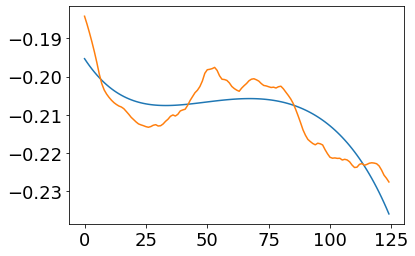

In [68]:
plt.plot(cfit)
plt.plot(slajan[10,:,15].dropna(dim = 'eta_rho').values)

A third order fit is okay, but not great. Try using np polyfit and polyval for fourth order

In [76]:
model = np.polyfit(slajan[10,:,23].dropna(dim = 'eta_rho').lat_rho.values, 
                   slajan[10,:,23].dropna(dim = 'eta_rho').values,
                   4
                  )
predicted = np.polyval(model, slajan[10,:,23].dropna(dim = 'eta_rho').lat_rho.values)

TypeError: expected 1D vector for x

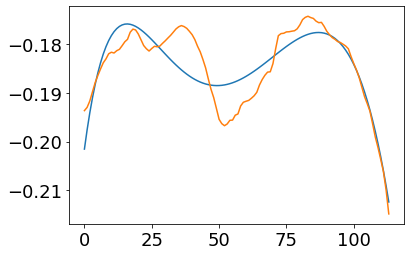

In [75]:
plt.plot(predicted)
plt.plot(slajan[10,:,23].dropna(dim = 'eta_rho').values)

Let's expand this to the entire dataset. Got to do a double loop for each track, but first let's do one at a tiem

/home/dylan/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/dylan/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


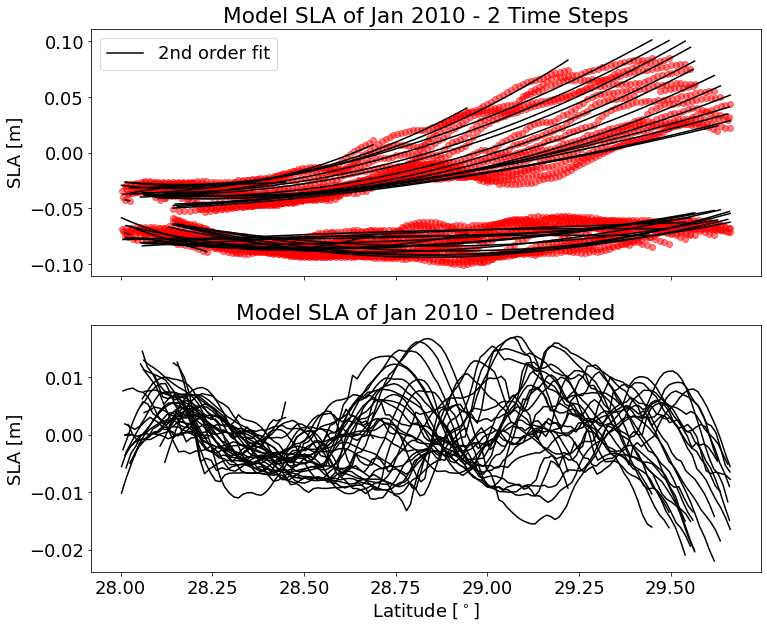

In [215]:
fig, ax = plt.subplots(2, figsize=(12,10))

fit = []
for j in range(len(slajan[:2,0,:])):
    for i in range(len(slajan[0,0,::2])):
        model = np.polyfit(slajan[j,:,i].dropna(dim = 'eta_rho').lat_rho.values, 
                   slajan[j,:,i].dropna(dim = 'eta_rho').values,
                   2
                  )
        predicted = np.polyval(model, 
                               slajan[j,:,i].dropna(dim = 'eta_rho').lat_rho.values
                              )
        scat = ax[0].scatter(slajan[j,:,i].dropna(dim = 'eta_rho').lat_rho.values,
                    (slajan[j,:,i].dropna(dim = 'eta_rho').values), 
                     color = 'r',  alpha = 0.5, label = 'test')
        ln = ax[0].plot(slajan[j,:,i].dropna(dim = 'eta_rho').lat_rho.values,
                     predicted, 
                     color = 'k',)
        
        ax[1].plot(slajan[j,:,i].dropna(dim = 'eta_rho').lat_rho.values,
                   slajan[j,:,i].dropna(dim = 'eta_rho').values-predicted, 
                   color = 'k')
        fit.append(predicted)
        
        ax[0].set_ylabel('SLA [m]')
        ax[0].tick_params(labelbottom=False)  
        
        ax[1].set_ylabel('SLA [m]')
        ax[1].set_xlabel('Latitude [$^\circ$]')
        ax[0].set_title('Model SLA of Jan 2010 - 2 Time Steps')
        ax[1].set_title('Model SLA of Jan 2010 - Detrended')
        
ax[0].legend(ln, ['2nd order fit'])

In [193]:
slajan = sla.sel(ocean_time = '2010-1')[::20]
slajul = sla.sel(ocean_time = '2010-7')[::20]

In [192]:
slajan

,Array,Chunk
Bytes,4.88 MB,19.68 kB
Shape,"(248, 133, 37)","(1, 133, 37)"
Count,53267 Tasks,248 Chunks
Type,float32,numpy.ndarray


In [206]:
janstd = []
julstd = []

janmean = []
julmean = []


for j in range(len(slajan[:10,0,:])):
    for i in range(len(sla[0,0,:])):
        modeljan = np.polyfit(slajan[j,:,i].dropna(dim = 'eta_rho').lat_rho.values, 
                   slajan[j,:,i].dropna(dim = 'eta_rho').values,
                   2
                  )
        predictedjan = np.polyval(modeljan, 
                               slajan[j,:,i].dropna(dim = 'eta_rho').lat_rho.values
                              )
        modeljul = np.polyfit(slajul[j,:,i].dropna(dim = 'eta_rho').lat_rho.values, 
                   slajul[j,:,i].dropna(dim = 'eta_rho').values,
                   2
                  )
        predictedjul = np.polyval(modeljul, 
                               slajul[j,:,i].dropna(dim = 'eta_rho').lat_rho.values
                              )
        
        dtjan = slajan[j,:,i].dropna(dim = 'eta_rho').values-predictedjan
        dtjul = slajul[j,:,i].dropna(dim = 'eta_rho').values-predictedjul
        
        janmean.append(dtjan.mean())
        janstd.append(dtjan.std())
        julmean.append(dtjul.mean())
        julstd.append(dtjul.std())

/home/dylan/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/dylan/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/dylan/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/dylan/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/dylan/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/dylan/.local/lib/python3.7/site-packages/IPython/core/interactiveshel

In [207]:
jansars = np.array(janstd)
julsars = np.array(julstd)
jansarm = np.array(janmean)
julsarm = np.array(julmean)

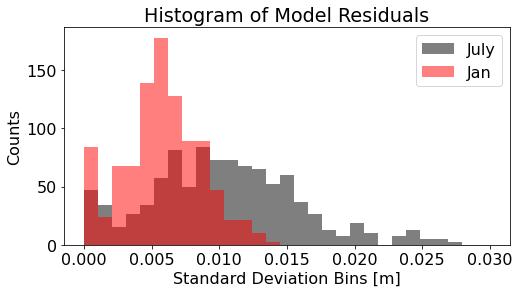

In [217]:
fig, ax = plt.subplots(1, figsize = (8, 4))


n, bins, hist = ax.hist(julsars, bins = np.linspace(0, 0.03, 30), density = True, 
                           color = 'k', histtype='stepfilled', alpha = 0.5, label = 'July')
ax.hist(jansars, bins = bins, density = True, 
           color = 'r', histtype='stepfilled', alpha = 0.5, label = 'Jan')

ax.legend()
ax.set_xlabel('Standard Deviation Bins [m]')
ax.set_ylabel('Counts')
ax.set_title('Histogram of Model Residuals')

plt.rcParams.update({'font.size': 16})

KeyboardInterrupt: 

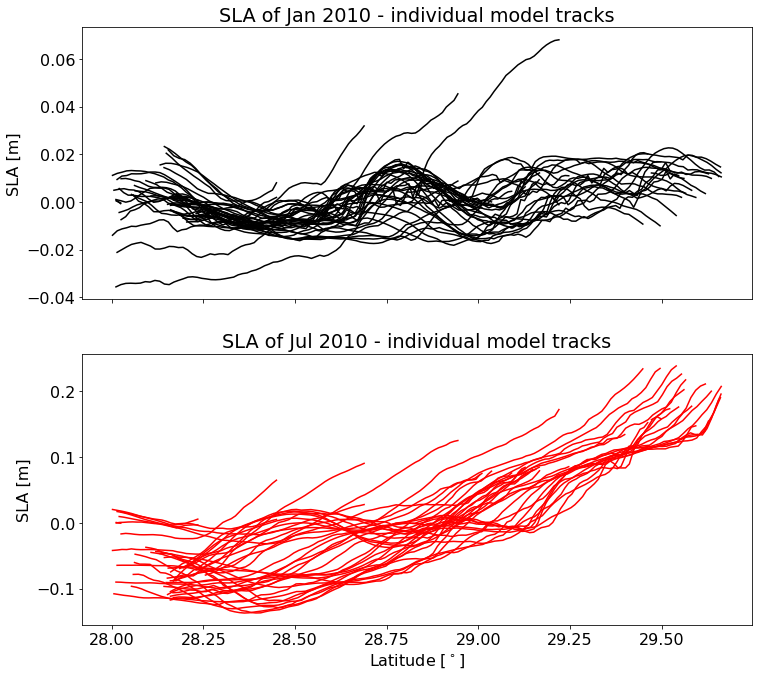

In [209]:
test = sla.sel(ocean_time = '2010-1')[::20]
test1 = sla.sel(ocean_time = '2010-7')[::20]

fig, ax = plt.subplots(2, figsize=(12,11))
for j in range(len(test[:,0,:])):
    for i in range(len(sla[0,0,:])):
        ax[0].plot(sla.lat_rho[:,i],(test[j,:,i]-(test[j,:,i].mean())), color = 'k') ; 
        ax[1].plot(sla.lat_rho[:,i],(test1[j,:,i]-(test1[j,:,i].mean())), color = 'r') ; 

        ax[0].set_ylabel('SLA [m]')
        ax[0].tick_params(labelbottom=False)  
        ax[1].set_ylabel('SLA [m]')
        ax[1].set_xlabel('Latitude [$^\circ$]')
        ax[0].set_title('SLA of Jan 2010 - individual model tracks')
        ax[1].set_title('SLA of Jul 2010 - individual model tracks')